# 🌍 ETL + SQL Analysis on Global Energy Dataset
This notebook walks you through a full ETL (Extract, Transform, Load) and SQL analysis project using a real-world energy dataset.

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt


## 📥 2. Load the Dataset
Ensure `owid-energy-data.csv` is in the same directory as this notebook.

In [4]:
# Load the dataset
df = pd.read_csv('owid-energy-data.csv')
# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Drop rows where 'country' or 'year' is missing
df = df.dropna(subset=['country', 'year'])

# Remove regional aggregates like "World", "Asia", "ASEAN (Ember)", etc.
exclude = ['World', 'Asia', 'Africa', 'Europe', 'North America', 'Oceania', 'European Union',
           'ASEAN (Ember)', 'Africa (Ember)', 'Non-OECD', 'OECD', 'South America (Ember)', 'G20', 'G7']

df = df[~df['country'].isin(exclude)]

# Now filter to only the important columns (drop the rest)
df = df[['country', 'year', 'primary_energy_consumption', 'energy_per_capita', 'greenhouse_gas_emissions', 'population']]

# Drop rows where all these columns are missing
df = df.dropna(subset=['primary_energy_consumption', 'energy_per_capita', 'greenhouse_gas_emissions', 'population'])

# Reset index after cleaning
df = df.reset_index(drop=True)

# Show the cleaned data
df.head()


,country,year,primary_energy_consumption,energy_per_capita,greenhouse_gas_emissions,population
0,Afghanistan,2000,5.914,302.595,0.12,20130279.0
1,Afghanistan,2001,4.664,236.892,0.15,20284252.0
2,Afghanistan,2002,4.428,210.862,0.12,21378081.0
3,Afghanistan,2003,5.208,229.968,0.22,22733007.0
4,Afghanistan,2004,4.810,204.231,0.18,23560598.0


## 🗃️ 4. Load Cleaned Data into SQLite

In [5]:
# Create SQLite database and load data
conn = sqlite3.connect('energy_data.db')
df.to_sql('energy', conn, if_exists='replace', index=False)
print('Data loaded into SQLite successfully!')

Data loaded into SQLite successfully!


## 🔍 5. Run SQL Queries

In [6]:
# Total energy consumption per year
query = '''
SELECT year, SUM(primary_energy_consumption) AS total_energy
FROM energy
GROUP BY year
ORDER BY year;
'''
df_total_energy = pd.read_sql(query, conn)
df_total_energy.head()

,year,total_energy
0,2000,241012.482
1,2001,243311.962
2,2002,247927.654
3,2003,256156.709
4,2004,268402.900


## 📈 6. Visualize Energy Use Over Time

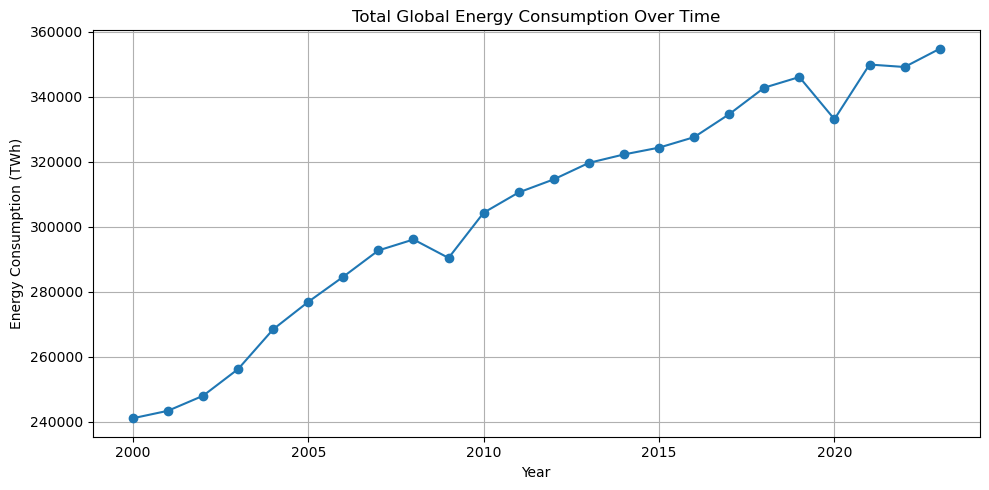

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(df_total_energy['year'], df_total_energy['total_energy'], marker='o')
plt.title('Total Global Energy Consumption Over Time')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (TWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔝 7. Top 5 Countries by Greenhouse Gas Emissions in 2020

In [8]:
query = '''
SELECT country, greenhouse_gas_emissions
FROM energy
WHERE year = 2020
ORDER BY greenhouse_gas_emissions DESC
LIMIT 5;
'''
pd.read_sql(query, conn)

,country,greenhouse_gas_emissions
0,Upper-middle-income countries,6489.74
1,High-income countries,4838.16
2,China,4716.12
3,Lower-middle-income countries,1783.59
4,United States,1664.57


## 📊 8. Average Per Capita Energy (2015–2020)

In [9]:
query = '''
SELECT country, AVG(energy_per_capita) AS avg_per_capita
FROM energy
WHERE year BETWEEN 2015 AND 2020
GROUP BY country
ORDER BY avg_per_capita DESC
LIMIT 10;
'''
pd.read_sql(query, conn)

,country,avg_per_capita
0,Qatar,212231.067667
1,Iceland,179515.216000
2,Singapore,159757.968667
3,Bahrain,148473.122500
4,United Arab Emirates,133592.272000
5,Trinidad and Tobago,132332.373667
6,Brunei,120692.678333
7,Canada,108831.718833
8,Kuwait,103929.903500
9,Norway,103868.885667
